In [1]:
import python_functions
# from python_functions import (
#     scroll_to_bottom,
#     get_filename_without_extension,
#     extract_site,
#     extract_date_heure,
#     extract_flight_data,
#     get_nav_infos1,
#     extract_flight_data2,
#     get_all_navs,
#     get_nav_infos_bs,
#     get_zip_adresses,
#     download_traces,
#     initiate_search,
#     get_syride_traces
# )
import params_scrap_syride

import zipfile
import os
import time
import requests
import json
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.remote.webelement import WebElement

%load_ext autoreload
%autoreload 2

In [2]:
from bs4 import BeautifulSoup
import re
import traceback

In [3]:
pilotes = params_scrap_syride.pilots
main_path = params_scrap_syride.main_path

In [4]:
path=main_path
base_url: str = "https://www.syride.com/fr/pilotes/"
pilot="Florent_Essar"
pilote=pilot


repertoire_pilote = path + pilot
list_of_known_traces = python_functions.initiate_search(main_repertoire=repertoire_pilote)
known_traces=list_of_known_traces

Dossiers trouvés, 133 trace(s) déjà téléchargée(s).


In [4]:
#new_navs, dict_navs = python_functions.get_all_navs(pilote=pilot, known_traces=list_of_known_traces)

In [5]:
base_url: str = "https://www.syride.com/fr/pilotes/"
pilote=pilot
known_traces=list_of_known_traces


# Configuration de Selenium
chrome_options = Options()
chrome_options.add_argument(
    "--headless"
)  # Exécuter le navigateur en mode headless (sans interface graphique)
webdriver_path = "/Users/Adrien/Documents/paramoteur/syride/analyze_traces/chromedriver-mac-x64/chromedriver"
chrome_service = Service(webdriver_path)
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

url = base_url + pilote
dict_navs = {}

driver.get(url)

if len(known_traces) >= 40:
    nb_scroll = 20
else:
    nb_scroll = 20

# Faire défiler jusqu'en bas de la page
driver.implicitly_wait(600)
python_functions.scroll_to_bottom(driver, nb_scroll=nb_scroll)

page_content = driver.page_source
soup = BeautifulSoup(page_content, 'html.parser')
driver.quit()

id_pattern = re.compile(r'^activite\d{5,10}$')
activities = soup.find_all(id=id_pattern)
len(activities)

Scrolling (total : 20)...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 


165

In [69]:
def get_nav_infos_bs(activity: BeautifulSoup, pilote: str):
    def get_activity_number(activity_id: str):
        id_activity = activity_id.replace("activite", "")
        return id_activity

    resultats = {}

    try:
        # Trouver le numéro d'activité
        id_activity = get_activity_number(
            activity_id=activity.get("id"),
        )
    except Exception:
        print("", "\n", traceback.format_exc())
        id_activity = "None"

    # identifier s'il s'agit d'une trace syride ou non
    element = activity.find(class_="photoGps")
    if element is not None:
        is_syride = True
    else:
        is_syride = False

    # identifier le numero d'activite et le type de vol
    try:
        type_pattern = re.compile(r'^type\d{5,10}$')
        elements_type_temp = activity.find(id=type_pattern)
        elements_type = elements_type_temp.text
        num_activite_temp = elements_type_temp.get("id")
        num_activite = num_activite_temp.replace("type","")
    except Exception:
        print(f"activite{id_activity}: Ceci n'est pas un vol")
        print("", "\n", traceback.format_exc())
        elements_type = "None"
        num_activite = "None"

    # identifier l'id du nom du site
    try:
        site_pattern = re.compile(r'^site\d{5,10}$')
        site_name_temp = activity.find(id=site_pattern)
    except Exception:
        print("", "\n", traceback.format_exc())
        site_name_temp = "None"

    # Récupérer les éléments de l'activté
    ul_elements = activity.find_all("ul")
    liste_data = [element.text for element in ul_elements]

    # Récupérer les éléments en fonction de is_syride
    if is_syride is True:
        if site_name_temp != "None":
            try:
                site_name = python_functions.extract_site(text=site_name_temp.text)
            except Exception:
                print("", "\n", traceback.format_exc())
                site_name = "None"
        else:
            site_name = "None"

        (
            date,
            heure,
            flight_time,
            voile,
            distance,
            instrument,
        ) = python_functions.extract_flight_data(data=liste_data)
        
    else:
        if site_name_temp != "None":
            try:
                site_name = site_name_temp.text
            except Exception:
                print("", "\n", traceback.format_exc())
                site_name = "None"
        else:
            site_name = "None"

        (
            date,
            _,
            flight_time,
            voile,
            _,
            _,
        ) = python_functions.extract_flight_data(data=liste_data)
        heure = "None"
        distance = "None"
        instrument = "None"

    resultats["pilote"] = pilote
    resultats["id_activite"] = id_activity
    resultats["num_activite"] = num_activite
    resultats["types"] = elements_type
    resultats["site"] = site_name
    resultats["date"] = date
    resultats["heure"] = heure
    resultats["flight_time"] = flight_time
    resultats["voile"] = voile
    resultats["distance"] = distance
    resultats["instrument"] = instrument
    resultats["is_syride"] = is_syride

    return num_activite, resultats

In [70]:
for activity in activities:
    try:
        num_activite, dict_activity = (
            get_nav_infos_bs(
                activity=activity,
                pilote=pilote
            )
        )
        dict_navs[f"{num_activite}"] = dict_activity
    except Exception:
        print("", "\n", traceback.format_exc())
        pass

dict_navs = {
    key: value for key, value in dict_navs.items() if key not in known_traces
}

final_list = list(set(dict_navs.keys()))
while "None" in final_list:
    final_list.remove("None")

print(f"{len(final_list)} nouvelles traces trouvées.")

activite1128738: Ceci n'est pas un vol
 
 Traceback (most recent call last):
  File "/var/folders/10/1m7q3nk502l57_kgv7_tyjch0000gp/T/ipykernel_17802/216430971.py", line 28, in get_nav_infos_bs
    elements_type = elements_type_temp.text
AttributeError: 'NoneType' object has no attribute 'text'

 
 Traceback (most recent call last):
  File "/var/folders/10/1m7q3nk502l57_kgv7_tyjch0000gp/T/ipykernel_17802/216430971.py", line 72, in get_nav_infos_bs
    site_name = site_name_temp.text
AttributeError: 'NoneType' object has no attribute 'text'

31 nouvelles traces trouvées.


In [71]:
def get_zip_adresses(
    pilote: str, traces: dict, base_url: str = "https://www.syride.com/fr/pilotes/"
) -> dict:
    """
    Récupère l'adresse du fichier ZIP
    """
    chrome_options = Options()
    chrome_options.add_argument(
        "--headless"
    )  # Exécuter le navigateur en mode headless (sans interface graphique)
    webdriver_path = "/Users/Adrien/Documents/paramoteur/syride/analyze_traces/chromedriver-mac-x64/chromedriver"
    chrome_service = Service(webdriver_path)
    driver = webdriver.Chrome(service=chrome_service, options=chrome_options)
    # driver = webdriver.Chrome(options=chrome_options)

    # Charger la page
    url = base_url + pilote

    updated_dict_navs = {}
    for i, dict_nav in enumerate(traces.items()):
        trace = dict_nav[0]
        dict_nav = dict_nav[1]
        print(f"{i+1} ", end="", flush=True)

        if dict_nav["is_syride"] is True:
            url1 = url + "/" + trace

            driver.get(url1)

            try:
                iframe_selector = "popupIframe"
                iframe = driver.find_element(By.ID, iframe_selector)

                # Basculer vers l'iframe
                driver.switch_to.frame(iframe)

                liens_iframe = driver.find_elements(By.TAG_NAME, "a")
                liens_download_zip = [
                    lien.get_attribute("href")
                    for lien in liens_iframe
                    if "downloadZIP" in lien.get_attribute("href")
                ]

                flight_datas_temp = driver.find_elements(By.CLASS_NAME, "volTexte")
                # flight_datas = [element.text for element in flight_datas_temp]
                flight_datas = [element.accessible_name for element in flight_datas_temp]

                (
                    date_act,
                    site_deco,
                    distance,
                    distance_cumulee,
                    vitesse_max,
                    vitesse_moyenne,
                    plafond,
                    gain,
                    flight_duration,
                    vario_max,
                    g_max,
                ) = python_functions.extract_flight_data2(flight_data=flight_datas)

                dict_nav["date_activite"] = date_act
                dict_nav["site_activite"] = site_deco
                dict_nav["distance_activite"] = distance
                dict_nav["distance_cumulee"] = distance_cumulee
                dict_nav["vitesse_max"] = vitesse_max
                dict_nav["vitesse_moyenne"] = vitesse_moyenne
                dict_nav["plafond"] = plafond
                dict_nav["gain"] = gain
                dict_nav["duree_vol"] = flight_duration
                dict_nav["vario_max"] = vario_max
                dict_nav["g_max"] = g_max
                dict_nav["adresse_zip"] = liens_download_zip[0]

                updated_dict_navs[trace] = dict_nav

                driver.switch_to.default_content()
            except (NoSuchElementException, StaleElementReferenceException, Exception):
                dict_nav["date_activite"] = None
                dict_nav["site_activite"] = None
                dict_nav["distance_activite"] = None
                dict_nav["distance_cumulee"] = None
                dict_nav["vitesse_max"] = None
                dict_nav["vitesse_moyenne"] = None
                dict_nav["plafond"] = None
                dict_nav["gain"] = None
                dict_nav["duree_vol"] = None
                dict_nav["vario_max"] = None
                dict_nav["g_max"] = None
                dict_nav["adresse_zip"] = None
                updated_dict_navs[trace] = dict_nav
                driver.switch_to.default_content()
        else:
            dict_nav["date_activite"] = None
            dict_nav["site_activite"] = None
            dict_nav["distance_activite"] = None
            dict_nav["distance_cumulee"] = None
            dict_nav["vitesse_max"] = None
            dict_nav["vitesse_moyenne"] = None
            dict_nav["plafond"] = None
            dict_nav["gain"] = None
            dict_nav["duree_vol"] = None
            dict_nav["vario_max"] = None
            dict_nav["g_max"] = None
            dict_nav["adresse_zip"] = None

            updated_dict_navs[trace] = dict_nav

    print("")

    # Fermer le navigateur Selenium
    driver.quit()

    return updated_dict_navs

In [72]:
new_navs = final_list.copy()
traces = dict_navs.copy()

In [73]:
if len(new_navs) > 0:
    print(f"Réupération des liens (total {len(new_navs)})...")
    updated_dict_navs = get_zip_adresses(pilote=pilot, traces=dict_navs)

    print("")
    print(f"Téléchargement des traces (total {len(updated_dict_navs)})...")
    for i, dict_item in enumerate(updated_dict_navs.items()):
        nav = dict_item[0]
        data_nav = dict_item[1]
        link = data_nav["adresse_zip"]
        print(f"{i+1} ", end="", flush=True)
        try:
            if data_nav["is_syride"] is True:
                python_functions.download_traces(main_repertoire=repertoire_pilote, nav=nav, link=link)
            else:
                if not os.path.exists(nav):
                    os.makedirs(nav)

            python_functions.save_flight_data(
                main_repertoire=repertoire_pilote, flight_data=data_nav
            )
        except Exception:
            print("", "\n", traceback.format_exc())
            print(f"Trace {nav} non sauvegardée")
            pass

else:
    print("Pas de nouvelles traces a telecharger.")

Réupération des liens (total 31)...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 



In [3]:
from pykml import parser

In [8]:
kml_file = "/Users/Adrien/Documents/paramoteur/syride/analyze_traces/syride_traces/AdrienM/traces/1914899/1914899.kml"
with open(kml_file, 'r') as f:
    root = parser.parse(f)


In [ ]:
from lxml import etree

# Charger le contenu du fichier .kml avec lxml
with open(kml_file, 'r') as f:
    doc = etree.parse(f)

# Définir les espaces de noms utilisés dans le fichier .kml
namespaces = {
    'kml': 'http://www.opengis.net/kml/2.2',
}

# Parcourir et explorer les données
for placemark in doc.findall('.//kml:Document', namespaces=namespaces):
    name_element = placemark.find('kml:name', namespaces=namespaces)
    name = name_element.text if name_element is not None else "Pas de nom"

    description_element = placemark.find('kml:Style/kml:LineStyle/kml:color', namespaces=namespaces)
    description = description_element.text if description_element is not None else "Pas de description"

    point_element = placemark.find('kml:Placemark/kml:LineString/kml:coordinates', namespaces=namespaces)
    coordinates = point_element.text if point_element is not None else "Pas de coordonnées"

    print(f"Nom : {name}")
    print(f"Couleur de la ligne : {description}")
    print(f"Coordonnées : {coordinates}\n")


In [85]:
coordinates

'Pas de coordonnées'

In [68]:
import geopandas as gpd
import fiona
import pandas as pd

fiona.drvsupport.supported_drivers['libkml'] = 'rw'
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

gdf_list = []
for layer in fiona.listlayers(kml_file):  
    print(layer)
    gdf = gpd.read_file(kml_file, driver='LIBKML', layer=layer)
    gdf_list.append(gdf)

gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
gdf

Flight of Adrien Moreau recorded with Syride 1420171135


,Name,Description,geometry
0,,,"LINESTRING Z (0.17093 45.55932 150.00000, 0.17..."


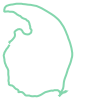

In [82]:
#help(gdf.geometry)
gdf_list[0].iloc[0]['geometry']

In [3]:
import zipfile
import os
import time
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.remote.webelement import WebElement

In [4]:
def extract_site(text:str) -> str:
    # Trouver l'index du premier "à" dans la chaîne
    index_de_a = text.find("à")

    # Trouver l'index de la première parenthèse ouvrante "(" après le premier "à"
    index_premiere_parenthese = text.find("(", index_de_a)

    # Extraire le texte entre le premier "à" et la première parenthèse
    texte_extrait = text[index_de_a + 1 : index_premiere_parenthese].strip()

    return(texte_extrait)

def extract_date_heure(date_h_data:str, date_hour:str) -> str:
    date_h_temp = date_h_data.split(":")[1]
    date_h = date_h_temp.split(" ")
    if date_hour == "date":
        return date_h[1]
    else:
        return date_h[3]

def extract_flight_data(data:list) -> str:

    def extract_flight_time(fl_time_data:str) -> str:
        fl_time_temp = fl_time_data.split(":")[1:]
        fl_time = fl_time_temp[0] + ":" + fl_time_temp[1] + ":" + fl_time_temp[2]
        return fl_time[1:-1]

    def extract_voile(voile_data:str) -> str:
        voile_data_temp = voile_data.split(":")[1]
        index_premiere_parenthese = voile_data_temp.find("(")
        voile = voile_data_temp[1:index_premiere_parenthese-1]
        return voile

    def extract_distance(distance_data:str) -> str:
        distance_data_temp = distance_data.split(":")[1]
        distance = distance_data_temp[1:-2]
        return distance

    def extract_alt_max(altitude_data:str) -> str:
        altitude_data_temp = altitude_data.split(":")[1]
        altitude = altitude_data_temp[1:-1]
        return altitude

    def extract_instrument(instrument_data:str) -> str:
        instrument_data_temp = instrument_data.split(":")[1]
        index_premiere_parenthese = instrument_data_temp.find("(")
        instrument = instrument_data_temp[1:index_premiere_parenthese-1]
        return instrument

    date = extract_date_heure(date_h_data=data[1], date_hour="date")
    heure = extract_date_heure(date_h_data=data[1], date_hour="heure")
    flight_time = extract_flight_time(fl_time_data=data[2])
    voile = extract_voile(voile_data=data[3])
    distance = extract_distance(distance_data=data[4])
    altitude = extract_alt_max(altitude_data = data[5])
    instrument = extract_instrument(instrument_data = data[6])
    
    return date, heure, flight_time, voile, distance, altitude, instrument

def get_nav_infos1(activity: WebElement):
    resultats={}
    # Trouver la div avec la classe "dateActivite" à l'intérieur de l'activité
    date_activite = activity.find_element(By.CLASS_NAME, "dateActivite").text

    # Trouver l'élément avec la classe "photoGps" à l'intérieur de l'activité
    photo_gps_element = activity.find_element(By.CLASS_NAME, "photoGps")
    photo_gps_url = python_functions.get_filename_without_extension(photo_gps_element.get_attribute("src"))

    # Trouver l'élément dont l'id commence par "type" et est suivi de 7 chiffres à l'intérieur de l'activité
    elements_type = activity.find_element(By.XPATH, "//*[starts-with(@id, 'type') and string-length(@id)=11]").text

    site_name = extract_site(activity.find_element(By.XPATH, "//*[starts-with(@id, 'site') and string-length(@id)=11]").text)

    ul_element = activity.find_elements(By.XPATH, ".//ul")
    liste_data = [element.text for element in ul_element]

    date, heure, flight_time, voile, distance, altitude, instrument = extract_flight_data(data=liste_data)

    # Parcourir les éléments "type" trouvés et récupérer leur texte
    #types = [element.text for element in elements_type]

    # # Ajouter les informations de l'activité au dict des résultats
    resultats["num_activite"] = photo_gps_url
    resultats["types"] = elements_type
    resultats["site"] = site_name
    resultats["date"] = date
    resultats["heure"] = heure
    resultats["flight_time"] = flight_time
    resultats["voile"] = voile
    resultats["distance"] = distance
    resultats["altitude"] = altitude
    resultats["instrument"] = instrument

    return photo_gps_url, resultats

In [7]:
base_url = "https://www.syride.com/fr/pilotes/"
pilote="AdrienM"
chrome_options = Options()
chrome_options.add_argument(
    "--headless"
)
webdriver_path = "/Users/Adrien/Documents/paramoteur/syride/analyze_traces/chromedriver-mac-x64/chromedriver"
chrome_service = Service(webdriver_path)
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

url = base_url + pilote
list_img_names = []
resultats = []

driver.get(url)

if len(known_traces)>=50:
    nb_scroll = 5
else:
    nb_scroll = 40
# Faire défiler jusqu'en bas de la page
python_functions.scroll_to_bottom(driver, nb_scroll=nb_scroll)

#activities = driver.find_elements(By.CLASS_NAME , "boxno")
activities = driver.find_elements(By.XPATH, "//*[contains(@id, 'activite') and string-length(@id)=15]")

dict_navs = {}
for activity in activities:
    num_activite, dict_activity = python_functions.get_nav_infos1(activity=activity, pilote=pilote)
    dict_navs[f"{num_activite}"] = dict_activity

dict_navs = {key: value for key, value in dict_navs.items() if key not in known_traces}


Scrolling (total : 5)...
1 2 3 4 5 


In [8]:
text00 = activities[0].text.split("\n")
text00

['Publié le 23/08/2023 - 20h24',
 '0',
 'Vol moteur à Site Secondigne Sur Belle 01 ( France / Nouvelle-Aquitaine)',
 'Nom du vol : 23-08-2023',
 'Date : 23/08/2023 - 19h20',
 'Temps de vol : 01:02:48s',
 'Voile utilisée : Daytona (ITV )',
 'Distance parcourue : 35km',
 'Altitude maximum : 881m',
 'Instrument utilisé : Evolution (v2.93)']

In [30]:
text00[0]

'P'

In [11]:
path=main_path
pilot="AdrienM"
repertoire_pilote = path + pilot
list_of_known_traces = python_functions.initiate_search(main_repertoire=repertoire_pilote)

new_navs, dict_new_navs = python_functions.get_all_navs(pilote=pilot, known_traces=list_of_known_traces)

Dossiers trouvés, 71 trace(s) déjà téléchargée(s).
Scrolling (total : 5)...
1 2 3 4 5 
1 nouvelles traces trouvées.


In [16]:
def get_zip_adresses(
    pilote: str, traces: dict, base_url: str = "https://www.syride.com/fr/pilotes/"
) -> dict:
    """
    Récupère l'adresse du fichier ZIP
    """
    chrome_options = Options()
    chrome_options.add_argument(
        "--headless"
    )  # Exécuter le navigateur en mode headless (sans interface graphique)
    driver = webdriver.Chrome(options=chrome_options)

    # Charger la page
    url = base_url + pilote

    updated_dict_navs = {}
    for i, dict_nav in enumerate(traces.items()):
        trace=dict_nav[0]
        dict_nav = dict_nav[1]
        print(f"{i+1} ", end="", flush=True)
        url1 = url + "/" + trace

        driver.get(url1)

        iframe_selector = "popupIframe"
        iframe = driver.find_element(By.ID, iframe_selector)

        # Basculer vers l'iframe
        driver.switch_to.frame(iframe)

        liens_iframe = driver.find_elements(By.TAG_NAME, "a")
        liens_download_zip = [
            lien.get_attribute("href")
            for lien in liens_iframe
            if "downloadZIP" in lien.get_attribute("href")
        ]

        flight_datas_temp = driver.find_elements(By.CLASS_NAME, "volTexte")
        flight_datas = [element.text for element in flight_datas_temp]

        distance_cumulee, vitesse_max, vitesse_moyenne, plafond, gain, vario_max, g_max = python_functions.extract_flight_data2(flight_data=flight_datas)

        dict_nav["adresse_zip"] = liens_download_zip[0]
        dict_nav["distance_cumulee"] = distance_cumulee
        dict_nav["vitesse_max"] = vitesse_max
        dict_nav["vitesse_moyenne"] = vitesse_moyenne
        dict_nav["plafond"] = plafond
        dict_nav["gain"] = gain
        dict_nav["vario_max"] = vario_max
        dict_nav["g_max"] = g_max
    
        updated_dict_navs[trace] = dict_nav
        
        driver.switch_to.default_content()

    print("")

    # Fermer le navigateur Selenium
    driver.quit()

    return updated_dict_navs

In [12]:
test_dict = {}
test_dict[f"{list(dict_new_navs.keys())[0]}"] = dict_new_navs[list(dict_new_navs.keys())[0]]
#test_dict[f"{list(dict_new_navs.keys())[1]}"] = dict_new_navs[list(dict_new_navs.keys())[1]]
test_dict

{'2252108': {'pilote': 'AdrienM',
  'num_activite': '2252108',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '23/08/2023',
  'heure': '19h20',
  'flight_time': '01:02:48',
  'voile': 'Daytona',
  'distance': '35',
  'instrument': 'Evolution'}}

In [13]:
flight_datas

NameError: name 'flight_datas' is not defined

In [14]:
def extract_flight_data2(flight_data: str):
    def extract_text_flight_data(text: str, ind_end: int, ind_start: int = 1):
        try:
            text_temp = text.split(":")[1]
            text = text_temp[ind_start:-ind_end]
        except Exception as excep:
            print(str(excep))
            text = "None"
        return text
    
    def extract_site(text: str) -> str:
        try:
            # Trouver l'index du premier ":" puis 1ere parenthese dans la chaîne
            index_de_ponct = text.find(":")
            index_premiere_parenthese = text.find("(", index_de_ponct)
            # Extraire le texte entre le premier ":" et la première parenthèse
            texte_extrait = text[index_de_ponct + 1 : index_premiere_parenthese].strip()
        except Exception as excep:
            print(str(excep))
            texte_extrait = "None"
        return texte_extrait

    def extract_flight_duration(fl_time_data: str) -> str:
        try:
            fl_time_temp = fl_time_data.split(":")[1:]
            fl_time = fl_time_temp[0] + ":" + fl_time_temp[1] + ":" + fl_time_temp[2]
            fl_time = fl_time[1:-1]
        except Exception as excep:
            print(str(excep))
            fl_time = "None"
        return fl_time

    date_act = None
    site_deco = None
    distance = None
    distance_cumulee = None
    vitesse_max = None
    vitesse_moyenne = None
    plafond = None
    gain = None
    flight_duration = None
    vario_max = None
    g_max = None

    for data in flight_data:
        if data.startswith('Date :'):
            date_act = data.split(":")[1].strip()
        elif data.startswith('Décollage :'):
            site_deco = extract_site(flight_data[1])
        elif data.startswith('Distance :'):
            distance = extract_text_flight_data(text=data, ind_end=2)
        elif data.startswith('Distance cumulée :'):
            distance_cumulee = extract_text_flight_data(text=data, ind_end=2)
        elif data.startswith('Vitesse max :'):
            vitesse_max = extract_text_flight_data(text=data, ind_end=4)
        elif data.startswith('Vitesse moyenne :'):
            vitesse_moyenne = extract_text_flight_data(text=data, ind_end=4)
        elif data.startswith('Plafond :'):
            plafond = extract_text_flight_data(text=data, ind_end=1)
        elif data.startswith('Gain :'):
            gain = extract_text_flight_data(text=data, ind_end=1)
        elif data.startswith('Temps de vol :'):
            flight_duration = extract_flight_duration(fl_time_data=data)
        elif data.startswith('Vario max :'):
            vario_max = extract_text_flight_data(text=data, ind_end=3)
        elif data.startswith('G max :'):
            g_max = extract_text_flight_data(text=data, ind_end=1)

    return (
        date_act,
        site_deco,
        distance,
        distance_cumulee,
        vitesse_max,
        vitesse_moyenne,
        plafond,
        gain,
        flight_duration,
        vario_max,
        g_max,
    )

In [15]:
extract_flight_data2(flight_data=flight_datas)

NameError: name 'flight_datas' is not defined

In [48]:
base_url: str = "https://www.syride.com/fr/pilotes/"
pilote="AdrienM"

chrome_options = Options()
chrome_options.add_argument(
    "--headless"
)  # Exécuter le navigateur en mode headless (sans interface graphique)
webdriver_path = "/Users/Adrien/Documents/paramoteur/syride/analyze_traces/chromedriver-mac-x64/chromedriver"
chrome_service = Service(webdriver_path)
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)


# Charger la page
url = base_url + pilote

traces = test_dict

updated_dict_navs = {}
for i, dict_nav in enumerate(traces.items()):
    trace=dict_nav[0]
    dict_nav = dict_nav[1]
    print(f"{i+1} ", end="", flush=True)
    url1 = url + "/" + trace

    driver.get(url1)

    iframe_selector = "popupIframe"
    iframe = driver.find_element(By.ID, iframe_selector)

    # Basculer vers l'iframe
    driver.switch_to.frame(iframe)

    liens_iframe = driver.find_elements(By.TAG_NAME, "a")
    liens_download_zip = [
        lien.get_attribute("href")
        for lien in liens_iframe
        if "downloadZIP" in lien.get_attribute("href")
    ]

    flight_datas_temp = driver.find_elements(By.CLASS_NAME, "volTexte")
    flight_datas = [element.accessible_name for element in flight_datas_temp]

    print(flight_datas)

    date_act, site_deco, distance, distance_cumulee, vitesse_max, vitesse_moyenne, plafond, gain, flight_duration, vario_max, g_max = python_functions.extract_flight_data2(flight_data=flight_datas)

    dict_nav["date_activite"] = date_act
    dict_nav["site_activite"] = site_deco
    dict_nav["distance_activite"] = distance
    dict_nav["distance_cumulee"] = distance_cumulee
    dict_nav["vitesse_max"] = vitesse_max
    dict_nav["vitesse_moyenne"] = vitesse_moyenne
    dict_nav["plafond"] = plafond
    dict_nav["gain"] = gain
    dict_nav["duree_vol"] = flight_duration
    dict_nav["vario_max"] = vario_max
    dict_nav["g_max"] = g_max
    dict_nav["adresse_zip"] = liens_download_zip[0]
    
    updated_dict_navs[trace] = dict_nav
    #driver.switch_to.default_content()

print("")

    # Fermer le navigateur Selenium
driver.quit()


1 ['Date : 23/08/2023', 'Décollage : Site Secondigne Sur Belle 01 ( France / Nouvelle-Aquitaine)', 'Voile : Daytona (ITV )', 'Nom du vol : 23-08-2023', 'Instrument : Evo (v2.93)', 'Fichiers : IGC, Google Earth, ZIP', "Qui j'ai croisé ? ", 'Distance : 35km', 'Distance cumulée : 46km', 'Vitesse max : 61km/h', 'Vitesse moyenne : 33.4km/h', 'Plafond : 881m', 'Gain : 827m', 'Temps de vol : 01:02:48s', 'Vario max : 4.4m/s', 'G max : 1.4g']



In [49]:
updated_dict_navs

{'2252108': {'pilote': 'AdrienM',
  'num_activite': '2252108',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '23/08/2023',
  'heure': '19h20',
  'flight_time': '01:02:48',
  'voile': 'Daytona',
  'distance': '35',
  'instrument': 'Evolution',
  'date_activite': '23/08/2023',
  'site_activite': 'Site Secondigne Sur Belle 01',
  'distance_activite': '35',
  'distance_cumulee': '46',
  'vitesse_max': '61',
  'vitesse_moyenne': '33.4',
  'plafond': '881',
  'gain': '827',
  'duree_vol': '01:02:48',
  'vario_max': '4.4',
  'g_max': '1.4',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2252108&key=0360311605661'}}

In [54]:
temp_dict = get_zip_adresses(pilote="Adrien", traces=test_dict)
temp_dict

1 2 


{'2190658': {'pilote': 'AdrienM',
  'num_activite': '2190658',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '22/07/2023',
  'heure': '09h08',
  'flight_time': '00:39:38',
  'voile': 'Daytona',
  'distance': '22',
  'altitude': '542',
  'instrument': 'Evolution',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2190658&key=0358665965364',
  'distance_cumulee': '24',
  'vitesse_max': '67',
  'vitesse_moyenne': '33.3',
  'plafond': '542',
  'gain': '497',
  'vario_max': '3.1',
  'g_max': '1.2'},
 '2181222': {'pilote': 'AdrienM',
  'num_activite': '2181222',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '16/07/2023',
  'heure': '08h42',
  'flight_time': '01:04:20',
  'voile': 'Daytona',
  'distance': '37',
  'altitude': '733',
  'instrument': 'Evolution',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2181222&key=0358413275648',
  'distance_cumulee': '46',
  'vitesse_max': '

In [70]:
def save_flight_data(main_repertoire:str, flight_data: dict):
    num_act = flight_data["num_activite"]
    file_name = main_repertoire + "/traces/" + f"{num_act}/" + f"{num_act}.json"
    with open(file_name, 'w') as fp:
        json.dump(flight_data, fp)
    print("Données de vol sauvegardées")

In [71]:
save_flight_data(main_repertoire=repertoire_pilote, flight_data=temp_dict[f"{list(temp_dict.keys())[0]}"])

/Users/Adrien/Documents/paramoteur/syride/analyze_traces/syride_traces/AdrienM/traces/2190658/2190658.json
Données de vol sauvegardées


In [59]:
print(f"Téléchargement des traces (total {len(temp_dict)})...")
for i, dict_item in enumerate(temp_dict.items()):
    nav = dict_item[0]
    data_nav = dict_item[1]
    print(data_nav)
    link = data_nav["adresse_zip"]
    print(f"{i+1} ", end="", flush=True)
    python_functions.download_traces(main_repertoire=repertoire_pilote, nav=nav, link=link)
print("")

Téléchargement des traces (total 2)...
{'pilote': 'AdrienM', 'num_activite': '2190658', 'types': 'Vol moteur', 'site': 'Site Secondigne Sur Belle 01', 'date': '22/07/2023', 'heure': '09h08', 'flight_time': '00:39:38', 'voile': 'Daytona', 'distance': '22', 'altitude': '542', 'instrument': 'Evolution', 'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2190658&key=0358665965364', 'distance_cumulee': '24', 'vitesse_max': '67', 'vitesse_moyenne': '33.3', 'plafond': '542', 'gain': '497', 'vario_max': '3.1', 'g_max': '1.2'}
1 

Archive extraite dans le répertoire : 2190658
{'pilote': 'AdrienM', 'num_activite': '2181222', 'types': 'Vol moteur', 'site': 'Site Secondigne Sur Belle 01', 'date': '16/07/2023', 'heure': '08h42', 'flight_time': '01:04:20', 'voile': 'Daytona', 'distance': '37', 'altitude': '733', 'instrument': 'Evolution', 'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2181222&key=0358413275648', 'distance_cumulee': '46', 'vitesse_max': '82', 'vitesse_moyenne': '34.5', 'plafond': '733', 'gain': '603', 'vario_max': '3.3', 'g_max': '1.4'}
2 Archive extraite dans le répertoire : 2181222



{'2190658': {'pilote': 'AdrienM',
  'num_activite': '2190658',
  'types': 'Vol moteur',
  'site': 'Site Secondigne Sur Belle 01',
  'date': '22/07/2023',
  'heure': '09h08',
  'flight_time': '00:39:38',
  'voile': 'Daytona',
  'distance': '22',
  'altitude': '542',
  'instrument': 'Evolution',
  'adresse_zip': 'https://www.syride.com/scripts/downloadZIP.php?idSession=2190658&key=0358665965364',
  'distance_cumulee': '24',
  'vitesse_max': '67',
  'vitesse_moyenne': '33.3',
  'plafond': '542',
  'gain': '497',
  'vario_max': '3.1',
  'g_max': '1.2'}}

In [61]:
repertoire_pilote

'/Users/Adrien/Documents/paramoteur/syride/analyze_traces/syride_traces/AdrienM'